### What do we want?

* We want to quantify our uncertainty
* We want to also use this to generate a model
* We want the answers as distributions not point estimates

In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

print('Running on PyMC3 v{}'.format(pm.__version__))

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5


In [2]:
data = pd.read_csv('renfe_small.csv')
#data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac=0.01, random_state=99)
data

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
4738,2019-04-17 08:03:35,VALENCIA,MADRID,2019-05-21 08:00:00,2019-05-21 09:47:00,AVE,33.65,Turista,Promo
8722,2019-05-09 07:12:41,MADRID,BARCELONA,2019-05-25 08:30:00,2019-05-25 11:15:00,AVE,85.10,Turista,Promo
13185,2019-04-24 11:21:26,MADRID,VALENCIA,2019-05-22 17:40:00,2019-05-22 19:20:00,AVE,51.15,Turista,Promo
24835,2019-04-14 12:36:29,SEVILLA,MADRID,2019-04-16 07:15:00,2019-04-16 09:55:00,AVE,53.40,Turista,Promo
190,2019-04-15 19:09:34,MADRID,BARCELONA,2019-05-20 14:30:00,2019-05-20 17:21:00,AVE,85.10,Turista,Promo
...,...,...,...,...,...,...,...,...,...
18849,2019-04-29 15:04:06,BARCELONA,MADRID,2019-05-17 15:50:00,2019-05-17 23:52:00,AVE-LD,NaN,Turista Plus,Promo
21557,2019-04-20 01:23:48,MADRID,VALENCIA,2019-04-22 17:48:00,2019-04-22 21:58:00,INTERCITY,42.90,Turista,Flexible
13858,2019-04-17 05:10:46,MADRID,BARCELONA,2019-04-17 14:00:00,2019-04-17 16:30:00,AVE,115.65,Preferente,Promo
24764,2019-04-14 04:14:33,MADRID,SEVILLA,2019-04-24 13:10:00,2019-04-24 20:51:00,MD-LD,34.35,Turista con enlace,Promo +


In [3]:
data.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
4738,2019-04-17 08:03:35,VALENCIA,MADRID,2019-05-21 08:00:00,2019-05-21 09:47:00,AVE,33.65,Turista,Promo
8722,2019-05-09 07:12:41,MADRID,BARCELONA,2019-05-25 08:30:00,2019-05-25 11:15:00,AVE,85.10,Turista,Promo
13185,2019-04-24 11:21:26,MADRID,VALENCIA,2019-05-22 17:40:00,2019-05-22 19:20:00,AVE,51.15,Turista,Promo


In [4]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.096899
train_class    0.000000
fare           0.000000
dtype: float64

In [5]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

C:\Users\MOHAMMED RIZWAN\AppData\Local\Temp\ipykernel_19804\698425401.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))
C:\Users\MOHAMMED RIZWAN\AppData\Local\Temp\ipykernel_19804\698425401.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))


In [6]:
for i in ['start_date', 'end_date']:
    data[i] = pd.to_datetime(data[i])

In [7]:
data.shape

(258, 9)

## Gaussian inferences

The KDE plot of the ticket price shows a Gaussian-like distribution, except for about several dozens of data points that are far away from the mean.

c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


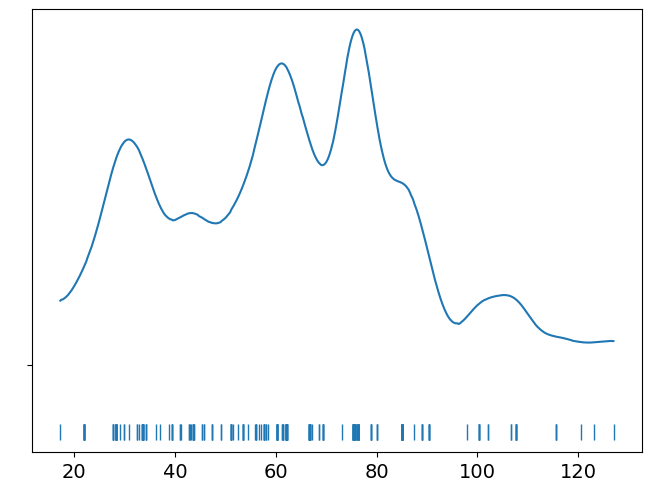

In [8]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);

Let's assume that a Gaussian distribution is a proper description of the ticket price. Since we do not know the mean or the standard deviation, we must set priors for both of them. Therefore, a reasonable model could be:

### Model

We will perform Gaussian inferences on the ticket price data. Here's some of the modelling choices that go into this.

Choices for price likelihood function:

The ticket price is modelled as a linear combination of the independent variables.
We assume that the ticket price is going to be normally distributed around the linear combination of independent variables with the same variance around the expected value.

That is how we proceed below:

#### We would instantiate the Models in PyMC3 like this.

* model specifications in PyMC3 are wrapped in a with-statement.

Choices of priors:

* μ, mean of a population. Normal distribution. Very wide. I do not know the possible values of μ, we can set priors reflecting our ignorance. From experience I know that train ticket price can not be lower than 0 or higher than 300, so I set the boundaries of the uniform distribution to be 0 and 300. You may have different experience and set the different boundaries. That is totally fine. And if you have more reliable prior information than I do, please use it!

* σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution, again, very wide.

Choices for ticket price likelihood function:

* y is an observed variable representing the data that comes from a Normal distribution with the parameters μ and σ.

* draw 1000 posterior samples using NUTS sampling
 
Using PyMC3, we can write the model as follows:

In [9]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

C:\Users\MOHAMMED RIZWAN\AppData\Roaming\Python\Python39\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


The "y" specifies the likelihood. This is the way in which we tell PyMC3 that we want to condition for the unknown on the knows (data). The observed values can be passed as a Python list, a tuple, a NumPy array, or a pandas DataFrame.

c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


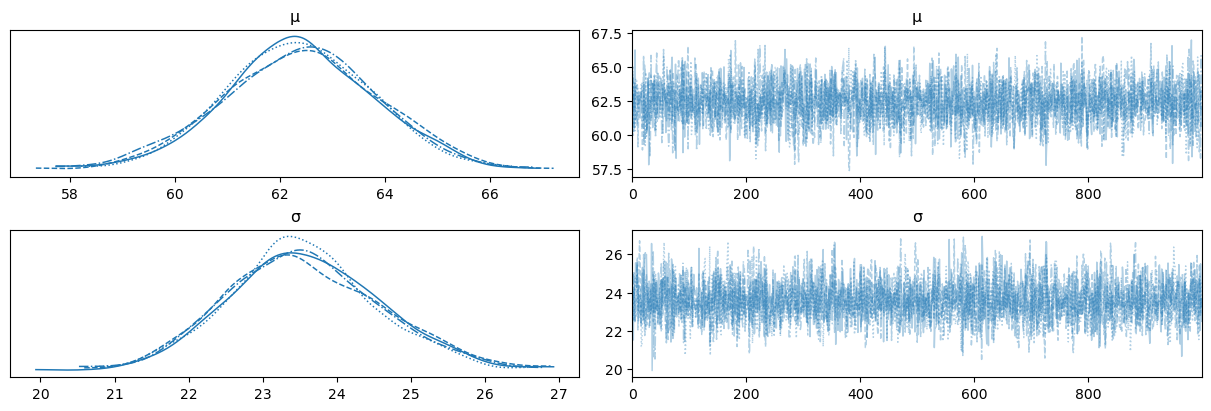

In [10]:
az.plot_trace(trace_g);

On the left, we have a KDE plot, – for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.

The above plot has one row for each parameter. For this model, the posterior is bi-dimensional, and so the above figure is showing the marginal distributions of each parameter.

There are a couple of things to see here. 

* Our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

* The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

We can plot a joint distributions of parameters. I don't see any correlation between these two parameters. This means we probably do not have collinearity in the model. This is good.

c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\plots\jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit f

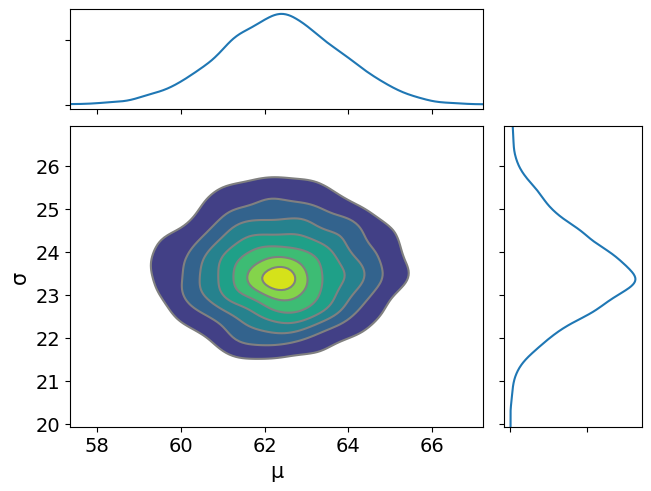

In [11]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

We can also have a detailed summary of the posterior distribution for each parameter:

In [12]:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,62.367,1.465,59.508,65.050,0.024,0.017,3628.0,2988.0,1.0
σ,23.556,1.028,21.643,25.483,0.018,0.013,3214.0,2431.0,1.0


We can also see the above summay visually by generating a plot with the mean and HPD of a distribution.

We get the mean, standard deviation (sd), and 94% HPD interval (hpd 3% and hpd 97%). we can use these numbers to interpret and report the results of a Bayesian inference.

c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


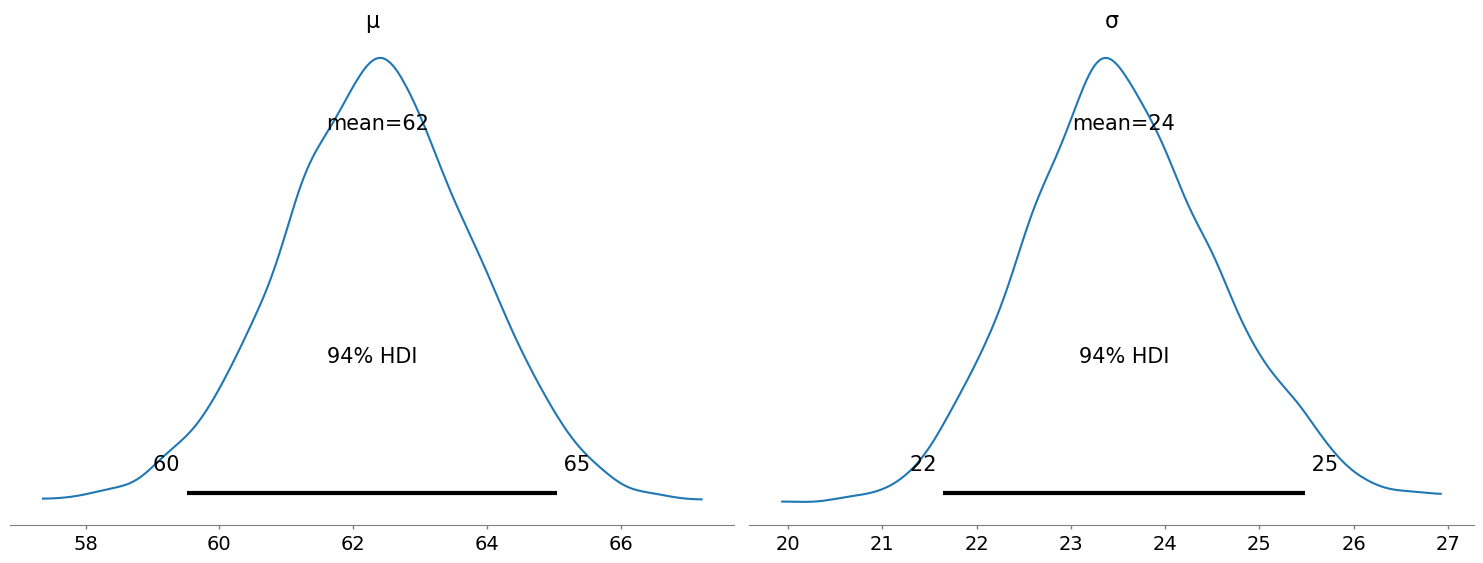

In [13]:
az.plot_posterior(trace_g);

Unlike Frequentist statistics, in Bayesian statistics, we get the entire distribution of the values.

Every time ArviZ computes and reports a HPD, it will use, by default, a value of 94%. please note that HPD intervals are not the same as confidence intervals. There is 94% probability the belief is between 63.8 and 64.4 for the mean ticket price.

We can verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

In [14]:
pm.gelman_rubin(trace_g)

AttributeError: module 'pymc3' has no attribute 'gelman_rubin'

In [15]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_g).values())

AttributeError: module 'pymc3' has no attribute 'gelman_rubin'

C:\Users\MOHAMMED RIZWAN\AppData\Local\Temp\ipykernel_19804\3084245180.py:1: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
  (pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));


NameError: name 'max_gr' is not defined

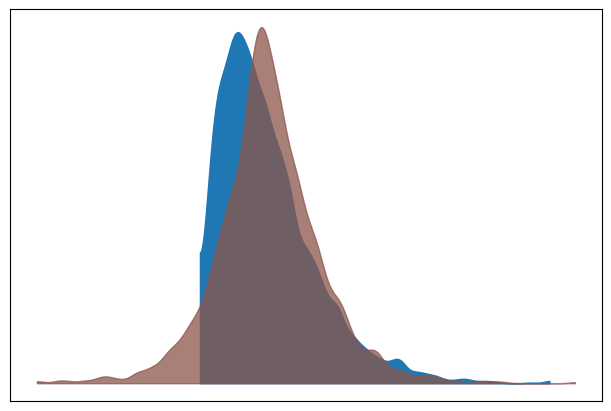

In [16]:
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

Our model has converged well and the Gelman-Rubin statistic looks good.

### Posterior Predictive Checks

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.

The following function will randomly draw 1000 samples of parameters from the trace. Then, for each sample, it will draw 25798 random numbers from a normal distribution specified by the values of μ and σ in that sample.

In [17]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)

In [18]:
np.asarray(ppc['y']).shape

(1000, 258)

Now, ppc contains 1000 generated data sets (containing 25798 samples each), each using a different parameter setting from the posterior.

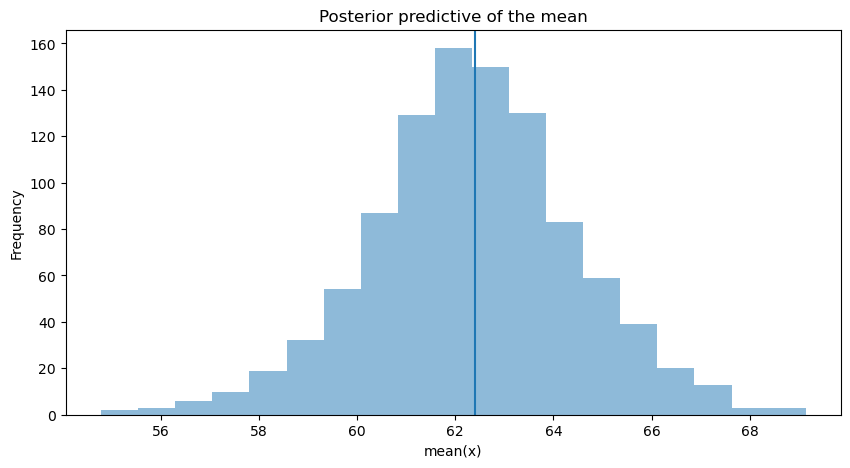

In [19]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

The inferred mean is very close to the actual ticket price mean.

### Group Comparison

We may be interested in how price compare under different fare types. we are going to focus on estimating the effect size, that is, quantifying the difference between two fare types. To compare fare types, we are going to use the mean of each fare type. Because we are Bayesian, we will work to obtain a posterior distribution of the differences of means between fare types.

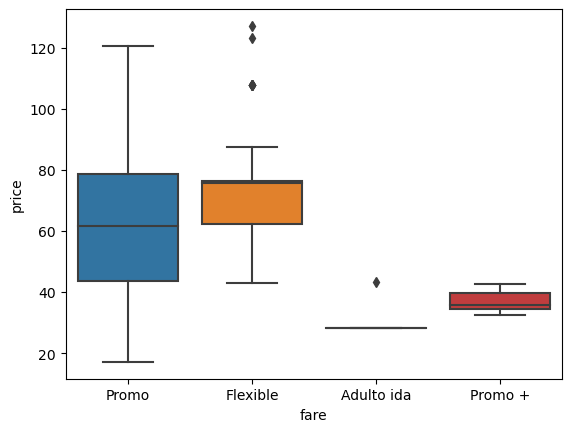

In [20]:
sns.boxplot(x='fare', y='price', data=data);

In [21]:
data.fare.unique()

array(['Promo', 'Flexible', 'Adulto ida', 'Promo +'], dtype=object)

We create three variables: the price variable, representing the ticket price, the idx variable, a categorical dummy variable to encode the fare types with numbers, and finally the groups variable, with the number of fare types (6):

### Estimate model parameters per group (fare type)

In [22]:
price = data['price'].values
idx = pd.Categorical(data['fare'],
                     categories=['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa', 'Individual-Flexible']).codes
groups = len(np.unique(idx))

The model for the group comparison problem is almost the same as the previous model. the only difference is that μ and σ are going to be vectors instead of scalar variables. This means that for the priors, we pass a shape argument and for the likelihood, we properly index the means and sds variables using the idx variable:

C:\Users\MOHAMMED RIZWAN\AppData\Roaming\Python\Python39\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 37 seconds.
There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.655380464334585, but should be close to 0.8. Try to increase the number of tuning steps.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7068849013004885, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


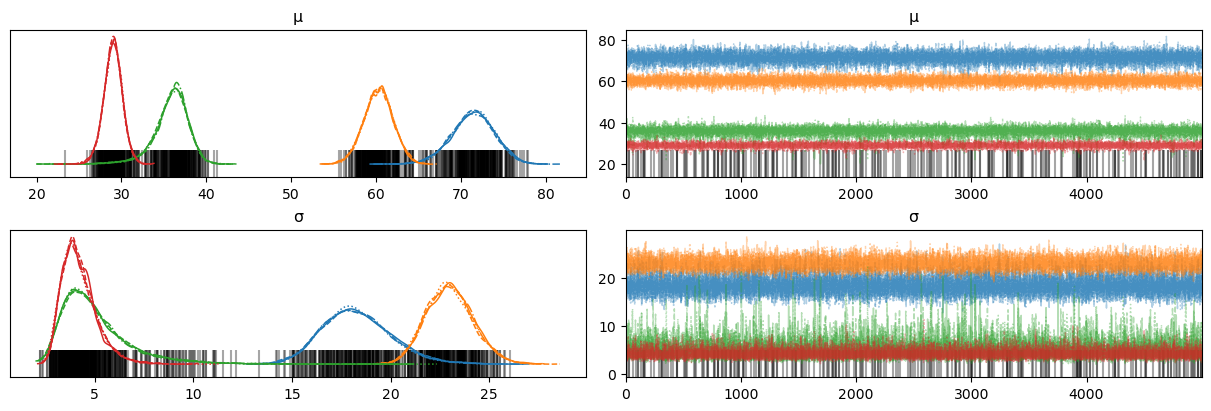

In [23]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=price)

    trace_groups = pm.sample(5000, tune=5000)
az.plot_trace(trace_groups);

This time, we get a KDE plot of μ and σ for every group (i.e. fare type).

In [24]:
flat_fares = az.from_pymc3(trace=trace_groups)
fares_gaussian = az.summary(flat_fares)
fares_gaussian

c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],71.398,2.501,66.847,76.215,0.023,0.016,12297.0,10901.0,1.0
μ[1],60.288,1.714,57.117,63.580,0.014,0.010,15642.0,13150.0,1.0
μ[2],35.845,2.096,31.865,39.425,0.021,0.015,12686.0,7976.0,1.0
μ[3],28.999,1.102,26.891,31.080,0.010,0.007,13535.0,10798.0,1.0
σ[0],18.296,1.747,15.306,21.799,0.016,0.011,12984.0,12302.0,1.0
σ[1],23.000,1.185,20.867,25.288,0.010,0.007,13876.0,12650.0,1.0
σ[2],5.026,1.842,2.488,8.395,0.020,0.015,10981.0,8504.0,1.0
σ[3],4.210,0.893,2.735,5.871,0.008,0.006,13191.0,11188.0,1.0


It is obvious that there are significant differnces between groups (i.e. fare types) on mean. 

To make it more visual, We plot the difference without between each fare type without repeating the comparison.

* Cohen's d is an appropriate effect size for the comparison between two means. Cohen's d introduces the variability of each group by using their standard deviations.

* probability of superiority (ps) is defined as the probability that a data point taken at random from one group has a larger value than one taken at random from another group.

IndexError: index 4 is out of bounds for axis 1 with size 4

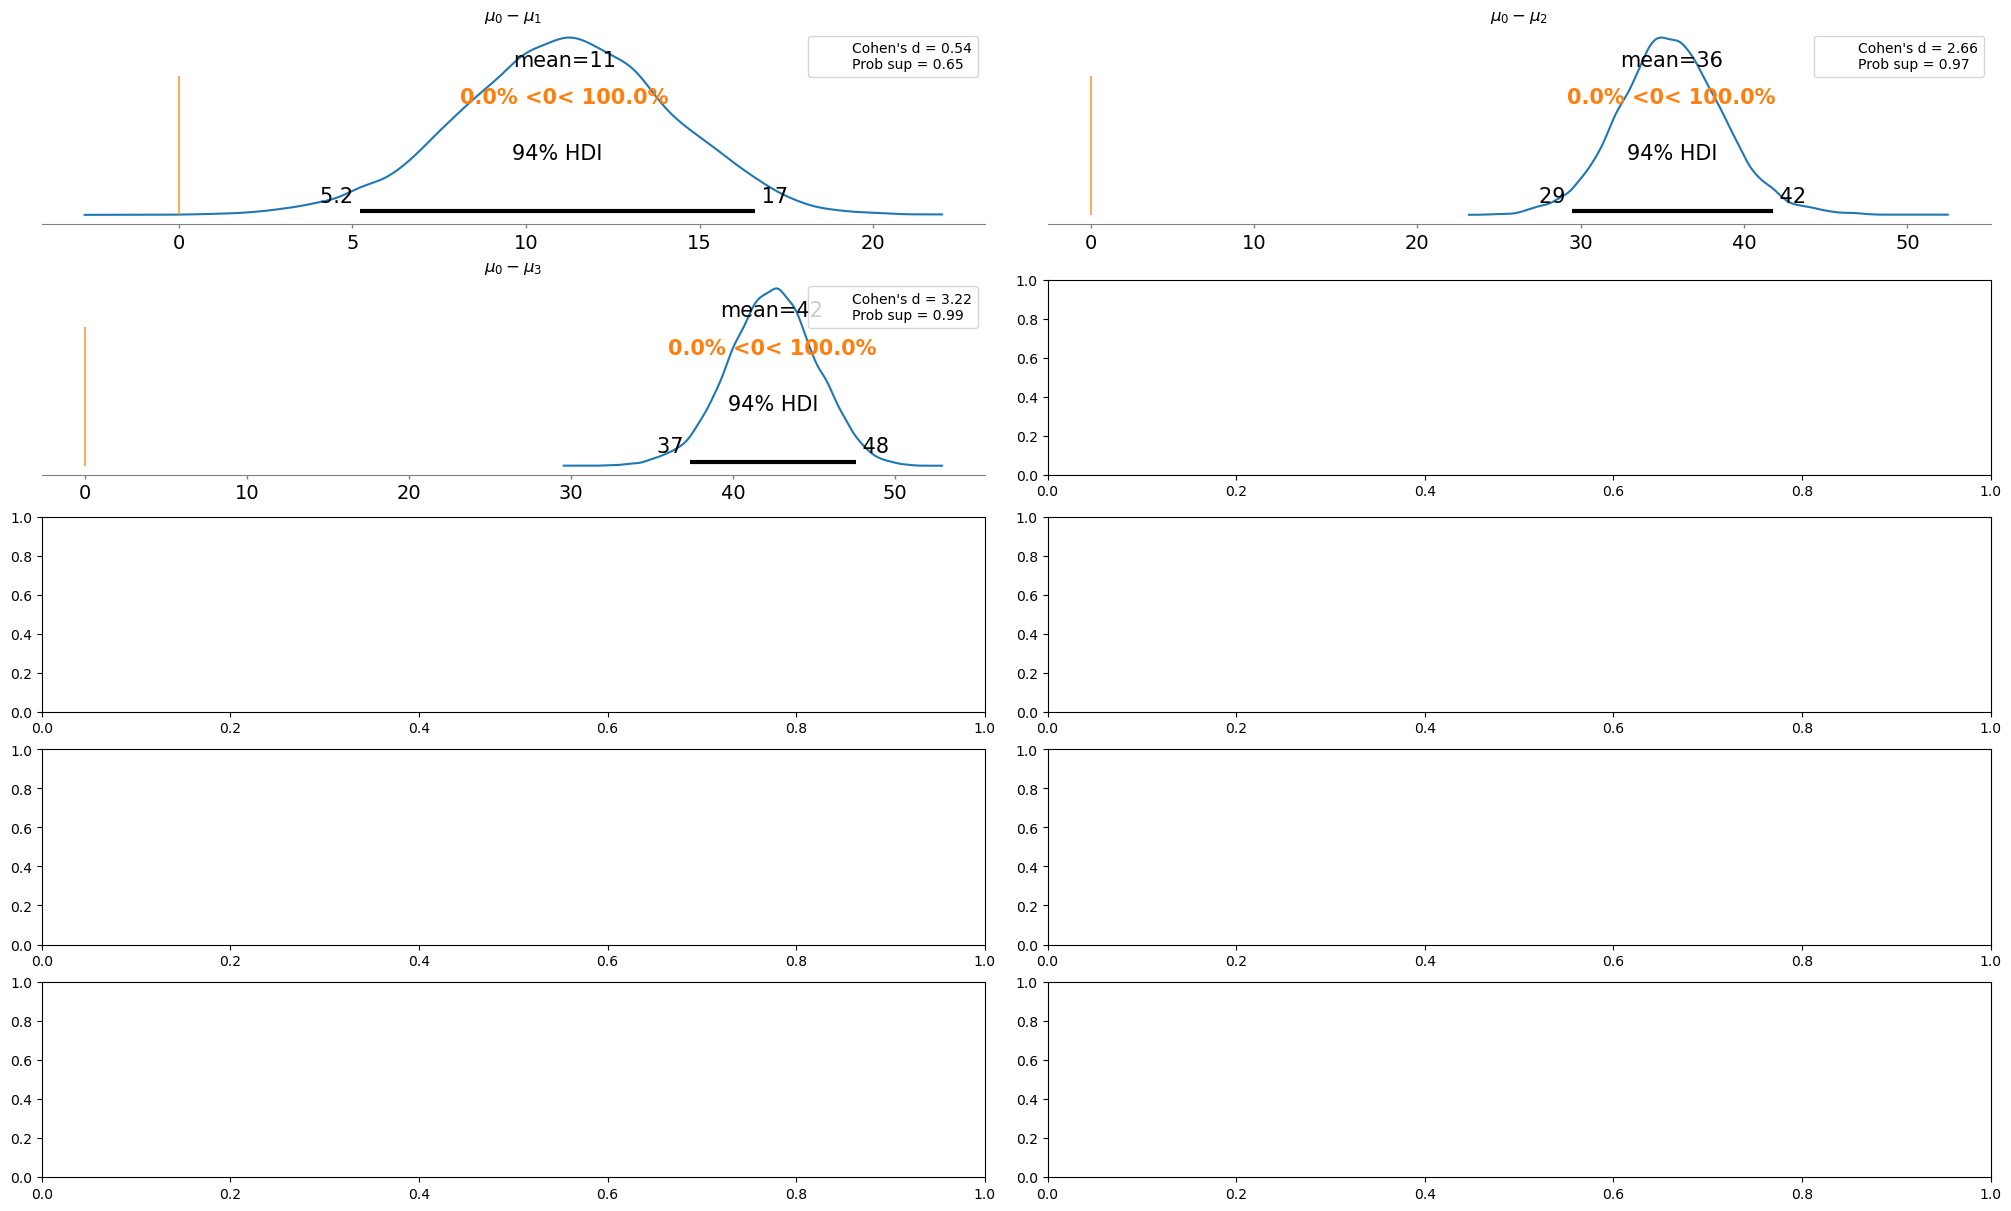

In [25]:
dist = stats.norm()

_, ax = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)

comparisons = [(i, j) for i in range(6) for j in range(i+1, 6)]
pos = [(k, l) for k in range(5) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_groups['μ'][:, i] - trace_groups['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_groups['σ'][:, i]**2 + trace_groups['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();

Basically, the above plot tells us that none of the above comparion cases where the 94% HPD includes the reference value of zero. This means for all the examples, we can rule out a difference of zero. The average differences range of 6.1 euro to 63.5 euro are large enough that it can justify for customers to purchase tickets according to different fare types.

### Bayesian Hierarchical Linear Regression

In [26]:
def replace_fare(fare):
    
    if fare == 'Adulto ida':
        return 1
    elif fare == 'Promo +':
        return 2
    elif fare == 'Promo':
        return 3
    elif fare == 'Flexible':
        return 4
    elif fare == 'Individual-Flexible':
        return 5
    elif fare == 'Mesa':
        return 6

data['fare_encode'] = data['fare'].apply(lambda x: replace_fare(x))

In [27]:
label_encoder = preprocessing.LabelEncoder() 
data['train_type_encode']= label_encoder.fit_transform(data['train_type'])

In [28]:
train_type_names = data.train_type.unique()
train_type_idx = data.train_type_encode.values

n_train_types = len(data.train_type.unique())

In [29]:
data[['train_type', 'price', 'fare_encode']].head()

,train_type,price,fare_encode
4738,AVE,33.65,3
8722,AVE,85.10,3
13185,AVE,51.15,3
24835,AVE,53.40,3
190,AVE,85.10,3


 We are interested in whether different train type affect the ticket price.

In [30]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    fare_est = α_tmp[train_type_idx] + β[train_type_idx]*data.fare_encode.values

    # Data likelihood
    fare_like = pm.Normal('fare_like', mu=fare_est, sd=eps, observed=data.price)

In [31]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)

C:\Users\MOHAMMED RIZWAN\AppData\Roaming\Python\Python39\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8376676860491853, but should be close to 0.9. Try to increase the number of tuning steps.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.814265553042678, but should be close to 0.9. Try to increase the number of tuning steps.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8402475504255392, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\Users\MOHAMMED RIZWAN\AppData\Local\Temp\ipykernel_19804\3224688326.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps']);
c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


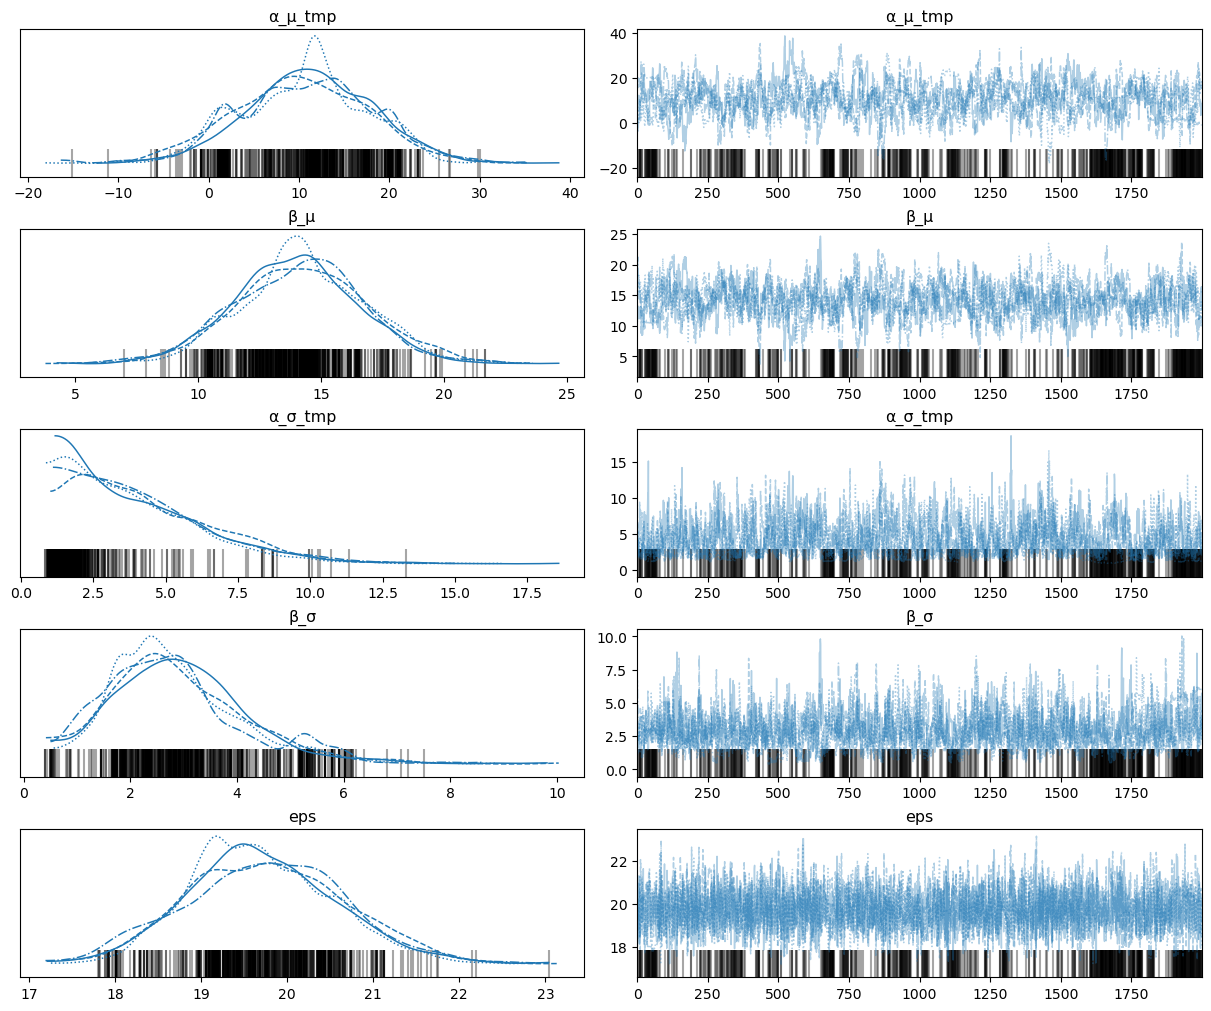

In [32]:
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps']);

The marginal posteriors in the left column are highly informative, "α_μ_tmp" tells us the group mean price levels, "β_μ" tells us that purchasing fare type "Promo +" increases price significantly compare to fare type "Adulto ida", and purchasing fare type "Promo" increases price significantly compare to fare type "Promo +", and so on (no mass under zero).

C:\Users\MOHAMMED RIZWAN\AppData\Local\Temp\ipykernel_19804\3897177016.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(hierarchical_trace, var_names=['α_tmp'], coords={'α_tmp_dim_0': range(5)});
c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


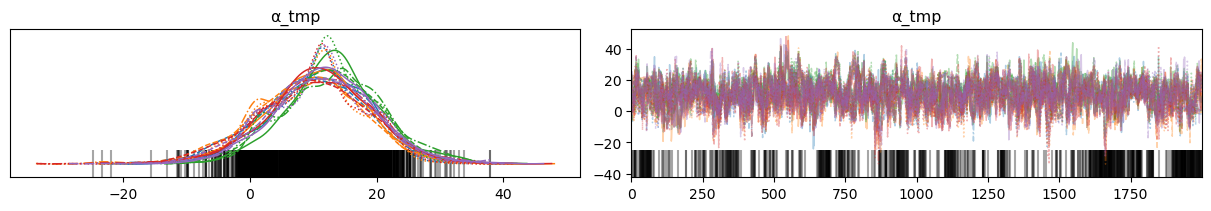

In [33]:
pm.traceplot(hierarchical_trace, var_names=['α_tmp'], coords={'α_tmp_dim_0': range(5)});

We can also see by looking at the marginals for "α_tmp" that there is quite some differences in prices between train types; the different widths are related to how much confidence we have in each paramter estimate – the more measurements per train type, the higher our confidence will be.

c:\Users\MOHAMMED RIZWAN\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


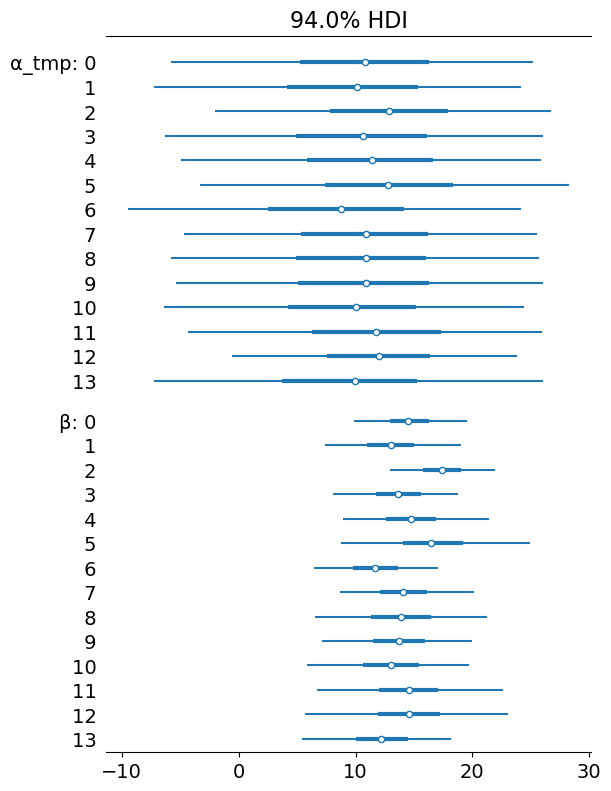

In [34]:
az.plot_forest(hierarchical_trace, var_names=['α_tmp', 'β'], combined=True);

In [35]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(data.price.values, ppc['fare_like'])

r2        0.292814
r2_std    0.011469
dtype: float64